## Assignment №3

In [31]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LassoLarsCV
import sklearn.metrics
import IPython

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


For the third assignment let's take, again, the dataset from one famous Kaggle competition: https://www.kaggle.com/c/titanic. With the tools of machine learning we should predict which passengers survived the Titanic tragedy. But we will now use it to predict the other variable.

In [14]:
titanic_df = pd.read_csv('titanic/train.csv')

Let's take a look at the data. Detailed description of all the features in the dataset can be found here: https://www.kaggle.com/c/titanic/data. Each row stands for one particular passenger.

In [15]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* survival: 0 = No, 1 = Yes
* pclass: Ticket class
* sex	
* Age: Age in years	
* sibsp: # of siblings / spouses aboard the Titanic	
* parch: # of parents / children aboard the Titanic	
* ticket: Ticket number	
* fare: Passenger fare	
* cabin: Cabin number	
* embarked: Port of Embarkation

In [16]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Let's take some features from this dataset that I think are the most interesting. We also drop all the NaN values from the table.

In [17]:
titanic_df = titanic_df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].dropna()

Now let's perform some feature engineering. First of all, let's transform the features 'SibSp' and 'Parch' into one new feature that will mean whether the passenger was on board alone or with relatives.

In [18]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
titanic_df['IsAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'IsAlone'] = 1
titanic_df = titanic_df.drop(['SibSp', 'Parch', 'FamilySize'], axis=1)

In [19]:
titanic_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3,male,22.0,7.2500,S,0
1,1,1,female,38.0,71.2833,C,0
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,0
4,0,3,male,35.0,8.0500,S,1


We have 2 categorical features in the remaining dataset: 'Sex' and 'Embarked'. We should transform them to numerical for the model. But we can not simply transform, for example, feature 'Embarked' this way: C (Cherbourg) => 1, Q (Queenstown) => 2, S (Southampton) => 3, because it will lead to some incorrect properties like Cherbourg + Queenstown = Southampton. That's why we should use one-hot encoding. Let's perform this transformation to 'Pclass' feature for the same reasons.

In [20]:
titanic_df = pd.get_dummies(titanic_df, columns=['Pclass', 'Sex', 'Embarked'])

In [21]:
titanic_df.head()

,Survived,Age,Fare,IsAlone,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,38.0,71.2833,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,26.0,7.9250,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,35.0,53.1000,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,35.0,8.0500,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


Now let's prepare two separate parts of data for training and testing. This time we will try to predict 'Fare' by using all the other features that we have.

In [46]:
targets = titanic_df['Fare']
predictors = titanic_df.drop(['Fare'], axis=1)

We need to standardize all the predictors for the regression model.

In [26]:
for feature in predictors.columns:
    predictors[feature] = preprocessing.scale(predictors[feature].astype('float64'))

Now we split the data into train and test:

In [29]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, targets, test_size=.3)

In [30]:
print pred_train.shape
print pred_test.shape
print tar_train.shape
print tar_test.shape

(498, 11)
(214, 11)
(498L,)
(214L,)


Let's fit a Lasso Regression model with 5 folds in cross validation

In [37]:
model = LassoLarsCV(cv=5, precompute=False).fit(pred_train, tar_train)

Variable names and regression coefficients:

In [47]:
dict(zip(predictors.columns, model.coef_))

{'Age': -1.9321491816091159,
 'Embarked_C': 3.2015006313536243,
 'Embarked_Q': 0.0,
 'Embarked_S': -0.27496728071841109,
 'IsAlone': -7.6831217870237332,
 'Pclass_1': 26.364843283918773,
 'Pclass_2': 0.0,
 'Pclass_3': -2.7837683054924907,
 'Sex_female': 0.0,
 'Sex_male': 0.0,
 'Survived': 2.0705263597687558}

Obviously, 'Pclass' is the most important feature. That makes a lot of sence. Next goes 'isAlone' feature. It can be explained in the way that passengers could have discounts when buying several tickets. Place of embarkation is also important, which, again, makes sence. 'Age' is important due to discounts to children \ older people. 'Sex' does not matter at all.

In total, the model selected 7 out of 11 features from the dataset.

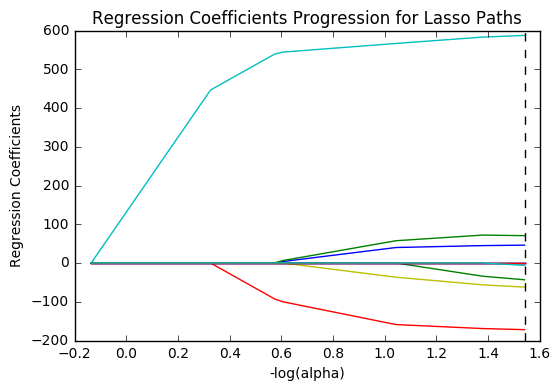

In [48]:
m_log_alphas = -np.log10(model.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')

Mean square error for each fold:

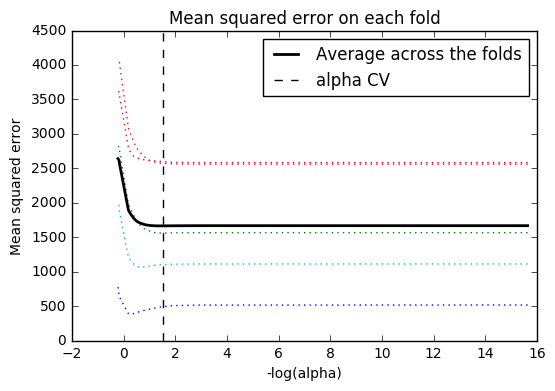

In [49]:
m_log_alphascv = -np.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

MSE from training and test data:

In [50]:
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE')
print(train_error)
print ('test data MSE')
print(test_error)

training data MSE
1578.16995299
test data MSE
1858.18328929


R-square from training and test data:

In [51]:
rsquared_train = model.score(pred_train,tar_train)
rsquared_test = model.score(pred_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print ('test data R-square')
print(rsquared_test)

training data R-square
0.400693741924
test data R-square
0.415994935325
